In [1]:
from pathlib import Path
import copy

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection

In [60]:
root_dir = Path("../tmp/ctd23/")

In [61]:
def cantor_pairing_sorted(a):
    assert a.shape[0] == 2 and a.shape[1] > 2
    asrt = np.sort(a, axis=0)

    return asrt[1] + ((asrt[0] + asrt[1])*(asrt[0] + asrt[1] + 1)) // 2

def cantor_inverse(z):
    f = lambda w: (w*(w+1)) // 2
    q = lambda z: np.floor( 0.5*(np.sqrt(8*z + 1) - 1) )

    a2 = z - f(q(z))
    a1 = q(z) - a2

    r = np.stack([a1,a2]).astype(int)
    assert r.shape[0] == 2 and r.shape[1] == len(z)
    return r

def eff_pur(pred_edges, true_edges):
    cantor_pred_edges = cantor_pairing_sorted(pred_edges)
    cantor_true_edges = cantor_pairing_sorted(true_edges)

    intersection = np.intersect1d(cantor_pred_edges, cantor_true_edges)

    return {
        "eff": len(intersection) / len(cantor_true_edges),
        "pur": len(intersection) / len(cantor_pred_edges),
    }

In [62]:
acorn_data_full = torch.load(root_dir / "feature_store/trainset/event000000000-graph.pyg")
acorn_data_full

Data(cluster_x_2=[268503], eta_angle_2=[268503], cluster_eta_2=[268503], hit_id=[268503], phi_angle_2=[268503], z=[268503], cluster_x_1=[268503], cluster_phi_1=[268503], phi_angle_1=[268503], cluster_z_2=[268503], cluster_eta_1=[268503], cluster_y_2=[268503], cluster_y_1=[268503], cluster_z_1=[268503], module_id=[268503], eta=[268503], x=[268503], region=[268503], phi=[268503], eta_angle_1=[268503], norm_y_1=[268503], norm_x_2=[268503], norm_z_1=[268503], y=[268503], norm_y_2=[268503], r=[268503], cluster_phi_2=[268503], cluster_r_1=[268503], norm_z_2=[268503], norm_x_1=[268503], cluster_r_2=[268503], track_edges=[2, 104852], radius=[104852], pt=[104852], redundant_split_edges=[104852], pdgId=[104852], eta_particle=[104852], primary=[104852], particle_id=[104852], nhits=[104852], config=[1], event_id='000000000')

In [63]:
cut = (acorn_data_full.pt > 1000) & (acorn_data_full.nhits >= 3) & (abs(acorn_data_full.pdgId) != 11) & acorn_data_full.primary.bool() & (abs(acorn_data_full.eta_particle) < 4)

print("Before:",len(acorn_data_full.particle_id))
print("Keep:",sum(cut))

acorn_data = copy.deepcopy(acorn_data_full)

acorn_data["track_edges"] = acorn_data["track_edges"][:,cut]
for key in ["radius", "pt", "redundant_split_edges", "pdgId", "eta_particle", "primary", "particle_id", "nhits"]:
    acorn_data[key] = acorn_data[key][cut]

Before: 104852
Keep: tensor(11945)


In [64]:
acorn_data

Data(cluster_x_2=[268503], eta_angle_2=[268503], cluster_eta_2=[268503], hit_id=[268503], phi_angle_2=[268503], z=[268503], cluster_x_1=[268503], cluster_phi_1=[268503], phi_angle_1=[268503], cluster_z_2=[268503], cluster_eta_1=[268503], cluster_y_2=[268503], cluster_y_1=[268503], cluster_z_1=[268503], module_id=[268503], eta=[268503], x=[268503], region=[268503], phi=[268503], eta_angle_1=[268503], norm_y_1=[268503], norm_x_2=[268503], norm_z_1=[268503], y=[268503], norm_y_2=[268503], r=[268503], cluster_phi_2=[268503], cluster_r_1=[268503], norm_z_2=[268503], norm_x_1=[268503], cluster_r_2=[268503], track_edges=[2, 11945], radius=[11945], pt=[11945], redundant_split_edges=[11945], pdgId=[11945], eta_particle=[11945], primary=[11945], particle_id=[11945], nhits=[11945], config=[1], event_id='000000000')

In [65]:
sum(acorn_data.particle_id == 0)

tensor(0)

In [66]:
len(np.unique(acorn_data.particle_id))

1088

In [67]:
acts_spacepoints = pd.read_csv(root_dir / "acts/csv/event000000000-spacepoint.csv")
acts_spacepoints.shape

(268503, 7)

In [68]:
acts_spacepoints.head(4)

,measurement_id,geometry_id,x,y,z,var_r,var_z
0,0,52776558133248,-33.275002,8.575,-265.0,0,0
1,1,52776558133248,-34.025002,3.000,-265.0,0,0
2,2,52776558133248,-34.049999,-9.725,-265.0,0,0
3,3,52776558133248,-34.424999,0.150,-265.0,0,0


In [69]:
# Ensure that number of spacepoints is consistent
assert acts_spacepoints.shape[0] == len(acorn_data.r)

In [70]:
# Ensure that the spacepoints are ordered in the same way
max_diff_x = max(acts_spacepoints["x"].to_numpy() - acorn_data.x.numpy())
max_diff_z = max(acts_spacepoints["z"].to_numpy() - acorn_data.z.numpy())
max_diff_x, max_diff_z

(3.104345876181469e-05, 6.580426247637661e-05)

In [71]:
assert max_diff_x < 1e-4 and max_diff_z < 1e-4

In [72]:
acts_truth_graph = pd.read_csv(root_dir / "acts/csv/event000000000-truth-graph.csv")
acts_truth_graph.shape

(12029, 3)

In [73]:
acts_truth_graph.head(3)

,edge0,edge1,weight
0,133949,134025,1
1,134025,134114,1
2,134114,164575,1


In [74]:
acorn_truth_graph_df = pd.DataFrame()
acorn_truth_graph_df["edge0"] = acorn_data.track_edges[0].numpy()
acorn_truth_graph_df["edge1"] = acorn_data.track_edges[1].numpy()
acorn_truth_graph_df["weight"] = np.ones(acorn_truth_graph_df.shape[0])
acorn_truth_graph_df.to_csv(root_dir / "acts/csv/event000000000-acorn-graph.csv", index=False)

In [75]:
acorn_truth_tracks = acorn_data.track_edges.numpy()
acts_truth_tracks = acts_truth_graph[["edge0", "edge1"]].to_numpy().T

In [76]:
cantor_acorn_truth_tracks = cantor_pairing_sorted(acorn_truth_tracks)
cantor_acts_truth_tracks = cantor_pairing_sorted(acts_truth_tracks)

In [77]:
intersection = np.intersect1d(cantor_acorn_truth_tracks, cantor_acts_truth_tracks)

### efficiency of ACTS wrt ACORN:

In [78]:
len(intersection) / len(cantor_acorn_truth_tracks)

0.9421515278359146

### efficiency of ACORN wrt ACTS:

In [79]:
len(intersection) / len(cantor_acts_truth_tracks)

0.935572366780281

In [80]:
intersection_edges = cantor_inverse(intersection)

cantor_missing_in_acts = np.setdiff1d(cantor_acorn_truth_tracks, cantor_acts_truth_tracks)
missing_in_acts = cantor_inverse(cantor_missing_in_acts)

cantor_additional_in_acts = np.setdiff1d(cantor_acts_truth_tracks, cantor_acorn_truth_tracks)
additional_in_acts = cantor_inverse(cantor_additional_in_acts)

In [81]:
intersection_edges.shape[1]

11254

In [82]:
missing_in_acts.shape[1]

691

In [83]:
additional_in_acts.shape[1]

775

In [84]:
def draw_edges(ax, edges, xaxis="z", yaxis="r", **kwargs):
    lines = []
    xvals = acorn_data[xaxis].numpy()
    yvals = acorn_data[yaxis].numpy()
    
    for src, dst in edges.T:
        lines.append([
            (xvals[src], yvals[src]),
            (xvals[dst], yvals[dst]),
        ])

    print("Number of edges", len(lines))
    collection = LineCollection(lines, **kwargs)

    ax.add_collection(collection)

    ax.set_xlim(min(xvals), max(xvals))
    ax.set_ylim(min(yvals), max(yvals))

Number of edges 691
Number of edges 775


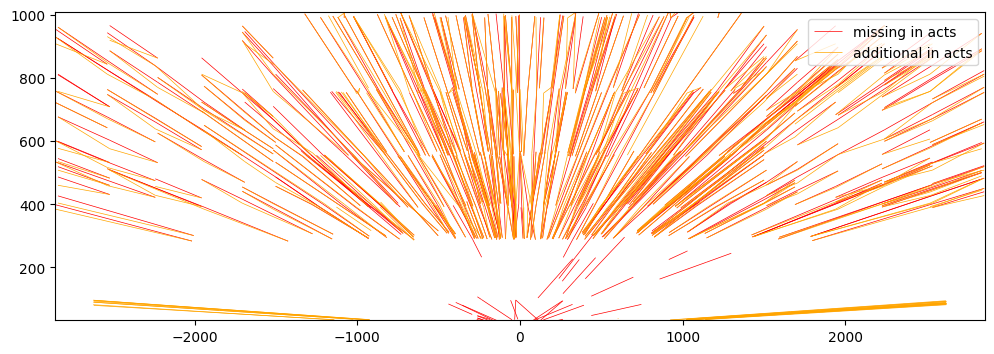

In [85]:
fig, ax = plt.subplots(figsize=(12,4))

#draw_edges(ax, intersection_edges, linewidths=0.5, colors="green", label="intersection",)
draw_edges(ax, missing_in_acts, linewidths=0.5, colors="red", label="missing in acts",)
draw_edges(ax, additional_in_acts, linewidths=0.5, colors="orange", label="additional in acts",)

ax.legend()

Number of edges 691
Number of edges 775


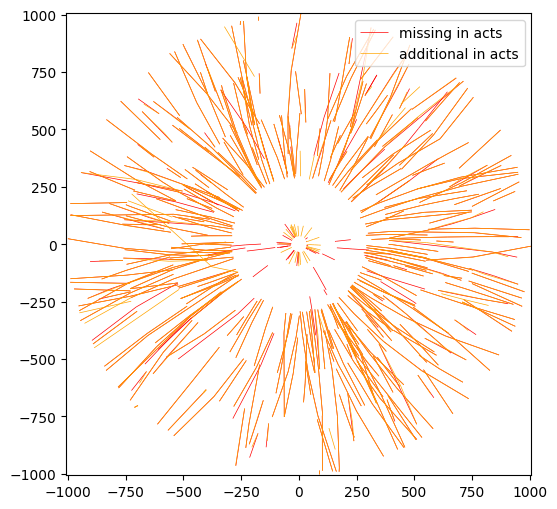

In [86]:
fig, ax = plt.subplots(figsize=(6,6))

#draw_edges(
#    ax, intersection_edges, "x", "y",
#    linewidths=0.5, colors="green", label="intersection"
#)
draw_edges(
    ax, missing_in_acts, "x", "y",
    linewidths=0.5, colors="red", label="missing in acts",
)
draw_edges(
    ax, additional_in_acts, "x", "y",
    linewidths=0.5, colors="orange", label="additional in acts",
)

ax.legend()

## Analyze missing edges

In [87]:
idxs_missing_in_acts = np.nonzero(np.isin(cantor_acorn_truth_tracks, cantor_missing_in_acts))[0]

['3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25']
['6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '23']
['13.0', '211.0', '321.0', '2212.0', '3112.0', '3222.0']
['13.0', '211.0', '321.0', '2212.0', '3222.0']
['1.0']
['1.0']


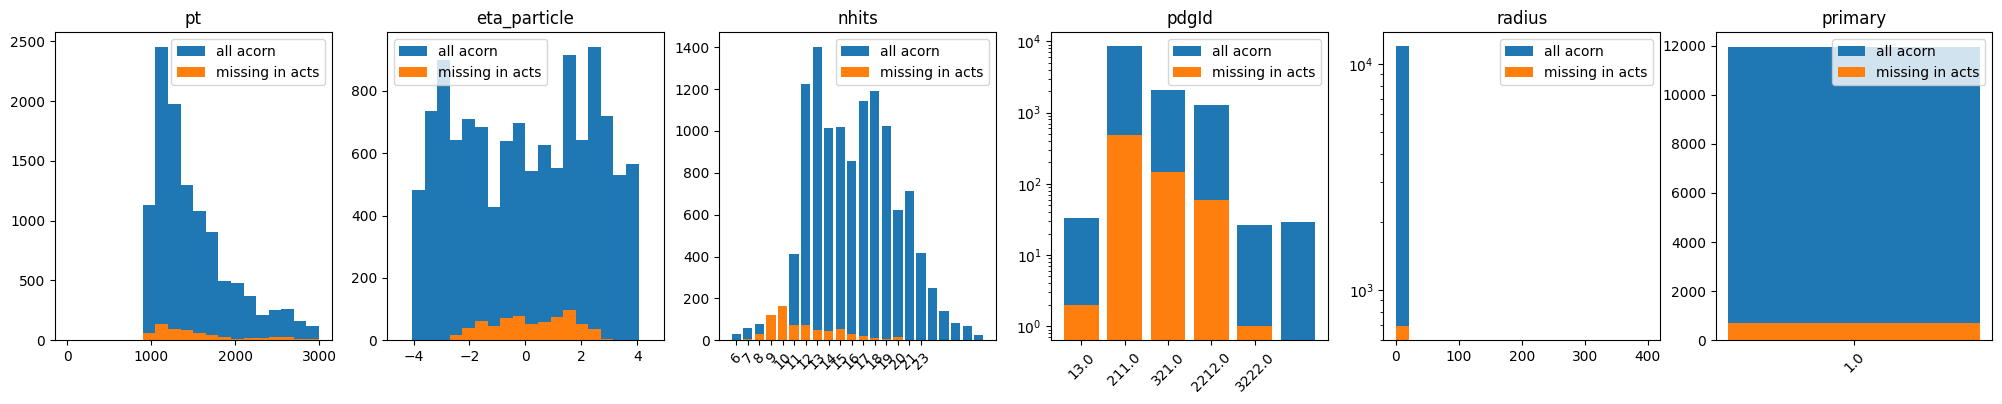

In [90]:
def compare_hist(ax, key, range, log=False):
    _, bins, _ = ax.hist(acorn_data[key], bins=20, range=range, label="all acorn")
    _, bins, _ = ax.hist(acorn_data[key][idxs_missing_in_acts], bins=bins, label="missing in acts")
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.set_title(key)

def compare_bar(ax, key, log=False, absolute=False):
    def f(ax, v, label):
        if absolute:
            v = abs(v)
        vals, counts = np.unique(v, return_counts=True)
        x = np.arange(len(vals))
        ax.bar(x, counts, label=label)
        ax.set_xticks(x)
        print([ str(l) for l in vals ])
        ax.set_xticklabels([ str(l) for l in vals ], rotation=45,)
        
    f(ax, acorn_data[key], label="all acorn")
    f(ax, acorn_data[key][idxs_missing_in_acts], label="missing in acts")
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.set_title(key)

fig, ax = plt.subplots(1,6, figsize=(25,4))

compare_hist(ax[0], "pt", (0,3000))
compare_hist(ax[1], "eta_particle", (-4.5,4.5))
compare_bar(ax[2], "nhits")
compare_bar(ax[3], "pdgId", log=True, absolute=True)
compare_hist(ax[4], "radius", (0,400), log=True)
compare_bar(ax[5], "primary")

## Standalone

In [216]:
#mmg_standalone_edges = pd.read_csv(root_dir / "standalone/event000000000_edges.csv")[["ivertex","overtex"]].to_numpy().T
#mmg_standalone_edges

In [27]:
eff_pur(pred_edges=mmg_standalone_edges, true_edges=acorn_truth_tracks)

{'eff': 0.5944522471910112, 'pur': 0.0019082743361335634}